# Dealing with IDEAL

Paper can be accessed [here](https://www.researchgate.net/publication/351949869_The_IDEAL_household_energy_dataset_electricity_gas_contextual_sensor_data_and_survey_data_for_255_UK_homes). Pullinger et al. (2021)'s fantastic dataset - cleaned and preprocessed.

Specifically, I have only extracted the `.gz` files with the combined electricity mains data (this is apparent data) which is measured in Watts. We further note that apparent data, according to all documentation (ranging from data documentation to the actual paper) is in 1 second (1 hz frequency) frequency.

We just need to put it into the form required.

Let's first unzip:

In [144]:
import gzip
import shutil
import os
import pandas as pd
import dask as dd
import seaborn as  sns
from datetime import datetime, timedelta
import numpy as np
import re
import tqdm

In [145]:
pd.options.mode.chained_assignment = None  # default='warn'

Unzip only a couple examples to test.

In [146]:
ideal_folder = '../../dataset/raw/ideal/'
temp_ideal_folder = '../../dataset/interim/ideal/'
ideal_zips = os.listdir(ideal_folder)

test_ideal_zips = ideal_zips[:3] # Test files

In [147]:
try:
    os.mkdir(temp_ideal_folder) # Make interim folder
except FileExistsError:
    print('file exists')

file exists


In [148]:
# Unzip files
for file_name in test_ideal_zips:
    with gzip.open(ideal_folder + file_name, 'rb') as f_in:
        with open(temp_ideal_folder + file_name[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [149]:
# Get file names
temp_files = [temp_ideal_folder + i for i in os.listdir(temp_ideal_folder)]

Fantastic.

Let's read these files and do some preliminary EDA using `pandas` before we move onto `dask` (as there's about $14 \text{gb}$ worth of files).

One file first:

In [150]:
df = pd.read_csv(temp_files[0], header=None, names=['datetime', 'watt'], parse_dates=['datetime'], infer_datetime_format=True)

In [151]:
# Quickly check NAs

df.isna().sum()

datetime    0
watt        0
dtype: int64

In [152]:
# Expected total seconds

expected_entries = (df.datetime.max() - df.datetime.min()).total_seconds()

In [153]:
len(df) / expected_entries

0.6073409471629233

This means we are missing 7.8% of seconds, which is a significant amount. Let's resample quickly.

In [154]:
df = df.resample('1s', on = 'datetime').mean()

<AxesSubplot:ylabel='datetime'>

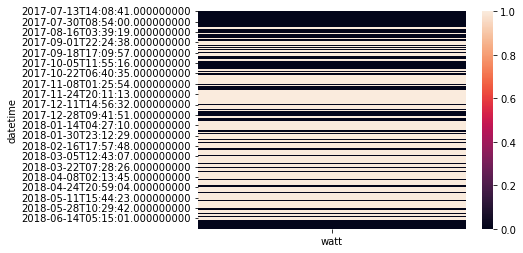

In [155]:
sns.heatmap(~df.isna())

Hmm interesting, let's run this experiment for all three test files:

In [156]:
df2 = pd.read_csv(temp_files[1], header=None, names=['datetime', 'watt'], parse_dates=['datetime'], infer_datetime_format=True)
df3 = pd.read_csv(temp_files[2], header=None, names=['datetime', 'watt'], parse_dates=['datetime'], infer_datetime_format=True)

In [157]:
df2 = df2.resample('1s', on = 'datetime').mean()
df3 = df3.resample('1s', on = 'datetime').mean()

In [158]:
df_all = df.join(df2, lsuffix='_1', rsuffix='_2').join(df3).rename({'watt': 'watt_3'}, axis=1)

<AxesSubplot:ylabel='datetime'>

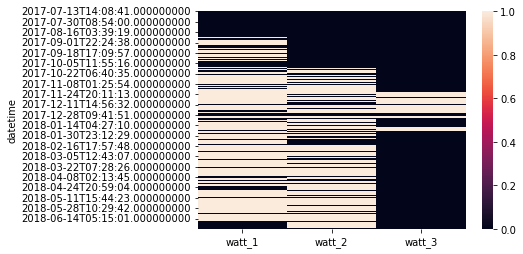

In [159]:
sns.heatmap(~df_all.isna())

In [160]:
df_all.isna().sum()

watt_1    11955793
watt_2    13689372
watt_3    26610176
dtype: int64

Taking my learnings from preprocessing the CERN dataset here, I think it's important to immediately set out my criteria, i.e.:

* Do I require geographical information (i.e., for better performance 'wisdom of neighbours' at a DCU level?)?
* Do I require same time information (i.e., for better time series performance)? or;
* Do I simply just care about having complete lots of data (i.e., groups of one hour data?)

While it would be interesting to investigate the first two, **I believe we start simple here and just care about the third dot point.**

Let's clean up the test files a bit using forward fill.

In [161]:
df_all = df_all.ffill(limit = 5)

In [162]:
df_all.isna().sum()

watt_1     6928680
watt_2    12956027
watt_3    26470616
dtype: int64

Helps a little bit.

<AxesSubplot:ylabel='datetime'>

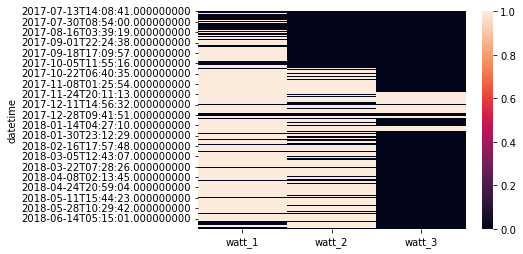

In [163]:
sns.heatmap(~df_all.isna())

Check to ensure minimal zeroes:

In [164]:
(df_all == 0).sum()

watt_1    289
watt_2     37
watt_3     58
dtype: int64

Next step is working out how to ensure that we have continuous data. Let's go from wide back to long:

In [165]:
df_melt = pd.melt(df_all.reset_index(), value_name='watt', var_name='house', id_vars='datetime')

In [166]:
df1_example = df_melt[df_melt['house'] == 'watt_1']

In [167]:
df1_example.head()

,datetime,house,watt
0,2017-07-13 14:08:41,watt_1,0.0
1,2017-07-13 14:08:42,watt_1,0.0
2,2017-07-13 14:08:43,watt_1,0.0
3,2017-07-13 14:08:44,watt_1,0.0
4,2017-07-13 14:08:45,watt_1,0.0


Okay, let's say we wanted at least continuous groups of 24 hours (86400 seconds). As we want to retain some time element of this, we must ensure that we start at midnight for each house. Let's force midnight start for one example:

In [168]:
df1_example.datetime.min()

Timestamp('2017-07-13 14:08:41')

Ah - not midnight! Force midnight start (nb: not sure if this will work in Dask...).

Actually, the solution is very simple: find the first day, then force it to Day 2.

In [169]:
df1_first_day = (df1_example.datetime.min() + pd.to_timedelta('1 day')).replace(hour = 0, minute = 0, second = 0, microsecond = 0)

In [170]:
df1_example_midnight = df1_example[df1_example.datetime >= df1_first_day]

Now, let's resample into one day lots.

In [171]:
def check_na(x):
    
    temp_df = pd.Series([x.watt.isna().sum(), len(x)])
    
    return temp_df

In [172]:
check_86400 = df1_example_midnight.resample('86400S', on='datetime', origin='start_day').apply(check_na).rename({0: 'missing', 1: 'entries'}, axis=1)

In [173]:
check_86400.head()

,missing,entries
datetime,,
2017-07-14,37838,86400
2017-07-15,63395,86400
2017-07-16,68943,86400
2017-07-17,75422,86400
2017-07-18,75276,86400


In [174]:
# Lots of 48s
len(check_86400)

352

Sense-check whether this number of lots is correct:

In [175]:
df1_example.datetime.max() - df1_example.datetime.min()

Timedelta('352 days 09:51:18')

In [176]:
# Number of NAs
full_entries_n = ((check_86400.missing == 0) & (check_86400.entries == 86400)).sum()

In [177]:
# Percentage
print('Pct of lots of 43200seconds to be dropped: {:.2f}%'.format(full_entries_n / len(check_86400) * 100))

Pct of lots of 43200seconds to be dropped: 0.00%


Great, let's drop. We can do this with the aux dataframe.

In [178]:
entries_to_keep = check_86400[(check_86400.missing == 0) & (check_86400.entries == 86400)].index

In [179]:
df1_example_midnight[df1_example_midnight.datetime.dt.normalize().isin(entries_to_keep)]

,datetime,house,watt


Fantastic.

### Apply to All

Get all file names

In [180]:
import pathlib
import dask.dataframe as dd
import os
import dask.multiprocessing
import dask

In [181]:
ideal_folder = '../../dataset/raw/ideal/'
temp_ideal_folder = '../../dataset/interim/ideal/'
final_ideal_folder = '../../dataset/final/ideal/'
ideal_zip_files = os.listdir(ideal_folder)
ideal_zip_files.remove('.ipynb_checkpoints')

In [182]:
pathlib.Path(temp_ideal_folder).mkdir(parents = True, exist_ok = True)
pathlib.Path(final_ideal_folder).mkdir(parents = True, exist_ok = True)

In [267]:
# Unzip files
for file_name in ideal_zip_files:
    with gzip.open(ideal_folder + file_name, 'rb') as f_in:
        with open(temp_ideal_folder + file_name[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [183]:
ideal_csv_files = [temp_ideal_folder + i for i in os.listdir(temp_ideal_folder) if i not in ('.ipynb_checkpoints', '.ipynb')]
ideal_house_names = [i.split('_')[0] for i in os.listdir(temp_ideal_folder) if i not in ('.ipynb_checkpoints', '.ipynb')]
ideal_output_files = [final_ideal_folder + i.split('_')[0] + '.csv' for i in os.listdir(temp_ideal_folder) if i not in ('.ipynb_checkpoints', '.ipynb')]

In [184]:
len(ideal_csv_files)

254

In [185]:
len(ideal_house_names)

254

In [187]:
len(ideal_output_files)

254

Let's just do this in `pandas` as `dask` keeps freezing and I cannot for the love of god work out why:

Rethink about just directly applying `pandas` instead. Furthermore, consider how much data we actually need (only 6 days per household or something, through a select time?). All of June perhaps? 86400 seconds * 290 households * 30 days 

Great.

In [189]:
# Parameters
ONE_DAY = pd.to_timedelta('1 day') # Constant variable
CONSECUTIVE_SECONDS = 86400 # check for full days
THRESHOLD_PCT = 0.01 # percentage threshold

def transform_and_save_ideal(input_file, output_file):
    
    curr_file = input_file

    df = pd.read_csv(curr_file,
                     header=None,
                     names=['datetime', 'watt'])

    # Convert to datetime
    df.datetime = pd.to_datetime(df.datetime, format = '%Y-%m-%d %H:%M:%S')

    # Change path to house number
    house_num = re.findall(r'(?:home)([0-9]*)', curr_file)[0]
    print('House: {}\n-----------------------------------------'.format(house_num))
    df['house'] = house_num

    # Convert house to int64 type
    df.house = df.house.astype('int64')
    
    # Run all transformations
    df = per_house_transform(df)
    
    # Transform watt to kilowatt
    df['kilowatt'] = df.watt / 1000
    df = df.drop('watt', axis=1)
    
    # Save file to parquet
    df.to_csv(output_file, index = False)
    
    # Return summary
    summary_df = pd.DataFrame(df.datetime.dt.date.unique(), columns=['date'])
    summary_df['house'] = house_num
    
    return summary_df 

def per_house_midnight_calculator(df):
    
    first_day = (df.datetime.min() + ONE_DAY).replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    last_day = df.datetime.max().replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    
    return df[(df.datetime >= first_day) & (df.datetime < last_day)]

def per_house_check_na(x):
    
    temp_df = pd.Series([x.watt.isna().sum(), len(x)])
    
    return temp_df

def per_house_check_24hr_groups(df):
    
    resampled_df = df.resample(str(CONSECUTIVE_SECONDS) + 'S', on ='datetime', origin='start_day')
    resampled_df = resampled_df.apply(check_na).rename(columns={0: 'missing', 1: 'entries'})

    # If fewer than 0.01% incorrect, let's propogate with mean of that date
    threshold_error = int(CONSECUTIVE_SECONDS * THRESHOLD_PCT / 100)
    days_to_fix = resampled_df[(resampled_df.missing <= threshold_error) & (resampled_df.entries == CONSECUTIVE_SECONDS)].index

    df['date'] = df.datetime.dt.normalize() # include a day column without time for convenience
    df = df[df.date.isin(days_to_fix)] # keep only days to fix to reduce size of dataframe (more efficient here than after)
    df['watt'] = df.groupby('date')['watt'].transform(lambda x: x.fillna(x.mean()))
    df = df.drop('date', axis=1) # drop it again
    
    return df

def per_house_transform(df):
    
    # Set to 1s and mean all if deuplicates
    df = df.set_index('datetime')
    df = df.resample('1s').mean()
    
    # Forward fill is missing
    df = df.ffill(limit = 5)
    df = df.reset_index()
    
    # Force midnight start
    df = per_house_midnight_calculator(df)
    
    # Check 24 hour groups
    df = per_house_check_24hr_groups(df)
    
    return df

Okay, so what we'll do is just find out which is the day with the most data, then we just use that instead.

In [190]:
summary_file = pd.DataFrame()

for i in tqdm.tqdm(range(len(ideal_csv_files))):
    temp_file = transform_and_save_ideal(ideal_csv_files[i], ideal_output_files[i])
    summary_file = pd.concat([summary_file, temp_file])

  0%|          | 0/254 [00:00<?, ?it/s]

House: 149
-----------------------------------------


  0%|          | 1/254 [00:21<1:32:04, 21.83s/it]

House: 214
-----------------------------------------


  1%|          | 2/254 [00:37<1:16:24, 18.19s/it]

House: 254
-----------------------------------------


  1%|          | 3/254 [00:43<52:52, 12.64s/it]  

House: 133
-----------------------------------------


  2%|▏         | 4/254 [01:38<2:02:16, 29.34s/it]

House: 236
-----------------------------------------


  2%|▏         | 5/254 [01:57<1:46:41, 25.71s/it]

House: 270
-----------------------------------------


  2%|▏         | 6/254 [02:12<1:30:15, 21.84s/it]

House: 229
-----------------------------------------


  3%|▎         | 7/254 [02:44<1:44:03, 25.28s/it]

House: 145
-----------------------------------------


  3%|▎         | 8/254 [03:09<1:43:46, 25.31s/it]

House: 275
-----------------------------------------


  4%|▎         | 9/254 [03:27<1:34:05, 23.04s/it]

House: 322
-----------------------------------------


  4%|▍         | 10/254 [03:37<1:16:32, 18.82s/it]

House: 256
-----------------------------------------


  4%|▍         | 11/254 [03:52<1:11:17, 17.60s/it]

House: 110
-----------------------------------------


  5%|▍         | 12/254 [04:41<1:49:56, 27.26s/it]

House: 155
-----------------------------------------


  5%|▌         | 13/254 [05:08<1:49:40, 27.31s/it]

House: 209
-----------------------------------------


  6%|▌         | 14/254 [05:47<2:03:05, 30.77s/it]

House: 100
-----------------------------------------


  6%|▌         | 15/254 [06:37<2:25:16, 36.47s/it]

House: 316
-----------------------------------------


  6%|▋         | 16/254 [06:49<1:55:48, 29.19s/it]

House: 250
-----------------------------------------


  7%|▋         | 17/254 [07:19<1:56:17, 29.44s/it]

House: 183
-----------------------------------------


  7%|▋         | 18/254 [07:45<1:51:09, 28.26s/it]

House: 325
-----------------------------------------


  7%|▋         | 19/254 [07:54<1:28:10, 22.51s/it]

House: 315
-----------------------------------------


  8%|▊         | 20/254 [08:02<1:11:05, 18.23s/it]

House: 186
-----------------------------------------


  8%|▊         | 21/254 [08:51<1:46:16, 27.37s/it]

House: 326
-----------------------------------------


  9%|▊         | 22/254 [08:57<1:20:55, 20.93s/it]

House: 215
-----------------------------------------


  9%|▉         | 23/254 [09:16<1:19:08, 20.55s/it]

House: 63
-----------------------------------------


  9%|▉         | 24/254 [10:26<2:15:12, 35.27s/it]

House: 272
-----------------------------------------


 10%|▉         | 25/254 [10:33<1:42:01, 26.73s/it]

House: 151
-----------------------------------------


 10%|█         | 26/254 [11:11<1:54:17, 30.07s/it]

House: 276
-----------------------------------------


 11%|█         | 27/254 [11:22<1:32:58, 24.57s/it]

House: 283
-----------------------------------------


 11%|█         | 28/254 [11:39<1:24:14, 22.37s/it]

House: 224
-----------------------------------------


 11%|█▏        | 29/254 [12:08<1:31:10, 24.31s/it]

House: 118
-----------------------------------------


 12%|█▏        | 30/254 [12:41<1:40:41, 26.97s/it]

House: 177
-----------------------------------------


 12%|█▏        | 31/254 [13:30<2:03:43, 33.29s/it]

House: 260
-----------------------------------------


 13%|█▎        | 32/254 [13:51<1:50:20, 29.82s/it]

House: 195
-----------------------------------------


 13%|█▎        | 33/254 [14:06<1:32:39, 25.16s/it]

House: 187
-----------------------------------------


 13%|█▎        | 34/254 [14:27<1:28:27, 24.12s/it]

House: 285
-----------------------------------------


 14%|█▍        | 35/254 [14:37<1:11:57, 19.72s/it]

House: 67
-----------------------------------------


 14%|█▍        | 36/254 [16:08<2:29:56, 41.27s/it]

House: 206
-----------------------------------------


 15%|█▍        | 37/254 [16:32<2:09:46, 35.88s/it]

House: 137
-----------------------------------------


 15%|█▍        | 38/254 [16:49<1:49:33, 30.43s/it]

House: 147
-----------------------------------------


 15%|█▌        | 39/254 [17:32<2:02:32, 34.20s/it]

House: 115
-----------------------------------------


 16%|█▌        | 40/254 [17:56<1:51:07, 31.16s/it]

House: 304
-----------------------------------------


 16%|█▌        | 41/254 [18:08<1:30:07, 25.39s/it]

House: 249
-----------------------------------------


 17%|█▋        | 42/254 [18:21<1:16:24, 21.63s/it]

House: 302
-----------------------------------------


 17%|█▋        | 43/254 [18:30<1:02:40, 17.82s/it]

House: 71
-----------------------------------------


 17%|█▋        | 44/254 [19:17<1:32:55, 26.55s/it]

House: 332
-----------------------------------------


 18%|█▊        | 45/254 [19:21<1:08:54, 19.78s/it]

House: 225
-----------------------------------------


 18%|█▊        | 46/254 [19:42<1:09:46, 20.13s/it]

House: 334
-----------------------------------------


 19%|█▊        | 47/254 [19:45<52:12, 15.13s/it]  

House: 218
-----------------------------------------


 19%|█▉        | 48/254 [19:59<50:52, 14.82s/it]

House: 295
-----------------------------------------


 19%|█▉        | 49/254 [20:09<45:39, 13.36s/it]

House: 323
-----------------------------------------


 20%|█▉        | 50/254 [20:20<42:20, 12.45s/it]

House: 180
-----------------------------------------


 20%|██        | 51/254 [20:41<50:48, 15.02s/it]

House: 243
-----------------------------------------


 20%|██        | 52/254 [20:57<52:18, 15.54s/it]

House: 59
-----------------------------------------


 21%|██        | 53/254 [22:06<1:45:39, 31.54s/it]

House: 284
-----------------------------------------


 21%|██▏       | 54/254 [22:19<1:26:15, 25.88s/it]

House: 317
-----------------------------------------


 22%|██▏       | 55/254 [22:23<1:04:07, 19.34s/it]

House: 191
-----------------------------------------


 22%|██▏       | 56/254 [22:59<1:20:01, 24.25s/it]

House: 74
-----------------------------------------


 22%|██▏       | 57/254 [24:15<2:10:37, 39.78s/it]

House: 97
-----------------------------------------


 23%|██▎       | 58/254 [25:08<2:22:37, 43.66s/it]

House: 160
-----------------------------------------


 23%|██▎       | 59/254 [25:33<2:04:12, 38.22s/it]

House: 329
-----------------------------------------


 24%|██▎       | 60/254 [25:49<1:41:34, 31.41s/it]

House: 168
-----------------------------------------


 24%|██▍       | 61/254 [26:34<1:54:08, 35.48s/it]

House: 216
-----------------------------------------


 24%|██▍       | 62/254 [26:49<1:34:06, 29.41s/it]

House: 274
-----------------------------------------


 25%|██▍       | 63/254 [27:10<1:25:23, 26.82s/it]

House: 303
-----------------------------------------


 25%|██▌       | 64/254 [27:23<1:11:52, 22.70s/it]

House: 69
-----------------------------------------


 26%|██▌       | 65/254 [28:47<2:09:57, 41.26s/it]

House: 105
-----------------------------------------


 26%|██▌       | 66/254 [29:32<2:12:37, 42.33s/it]

House: 169
-----------------------------------------


 26%|██▋       | 67/254 [30:22<2:19:18, 44.70s/it]

House: 122
-----------------------------------------


 27%|██▋       | 68/254 [32:17<3:23:14, 65.56s/it]

House: 188
-----------------------------------------


 27%|██▋       | 69/254 [32:53<2:54:51, 56.71s/it]

House: 227
-----------------------------------------


 28%|██▊       | 70/254 [33:07<2:15:05, 44.05s/it]

House: 232
-----------------------------------------


 28%|██▊       | 71/254 [33:28<1:53:11, 37.11s/it]

House: 158
-----------------------------------------


 28%|██▊       | 72/254 [33:59<1:46:50, 35.22s/it]

House: 77
-----------------------------------------


 29%|██▊       | 73/254 [34:38<1:49:34, 36.33s/it]

House: 245
-----------------------------------------


 29%|██▉       | 74/254 [35:00<1:35:53, 31.97s/it]

House: 335
-----------------------------------------


 30%|██▉       | 75/254 [35:06<1:12:42, 24.37s/it]

House: 199
-----------------------------------------


 30%|██▉       | 76/254 [35:30<1:12:09, 24.33s/it]

House: 318
-----------------------------------------


 30%|███       | 77/254 [35:43<1:01:17, 20.77s/it]

House: 141
-----------------------------------------


 31%|███       | 78/254 [35:55<53:27, 18.22s/it]  

House: 152
-----------------------------------------


 31%|███       | 79/254 [36:05<46:00, 15.77s/it]

House: 176
-----------------------------------------


 31%|███▏      | 80/254 [36:35<57:38, 19.87s/it]

House: 230
-----------------------------------------


 32%|███▏      | 81/254 [36:56<58:27, 20.28s/it]

House: 257
-----------------------------------------


 32%|███▏      | 82/254 [37:11<53:42, 18.74s/it]

House: 292
-----------------------------------------


 33%|███▎      | 83/254 [37:25<49:36, 17.41s/it]

House: 287
-----------------------------------------


 33%|███▎      | 84/254 [37:39<46:16, 16.34s/it]

House: 288
-----------------------------------------


 33%|███▎      | 85/254 [37:43<35:40, 12.67s/it]

House: 244
-----------------------------------------


 34%|███▍      | 86/254 [37:59<37:53, 13.53s/it]

House: 106
-----------------------------------------


 34%|███▍      | 87/254 [38:32<54:14, 19.49s/it]

House: 207
-----------------------------------------


 35%|███▍      | 88/254 [38:59<59:57, 21.67s/it]

House: 286
-----------------------------------------


 35%|███▌      | 89/254 [39:18<57:45, 21.00s/it]

House: 91
-----------------------------------------


 35%|███▌      | 90/254 [39:41<58:47, 21.51s/it]

House: 251
-----------------------------------------


 36%|███▌      | 91/254 [40:00<56:05, 20.65s/it]

House: 153
-----------------------------------------


 36%|███▌      | 92/254 [40:37<1:09:08, 25.61s/it]

House: 139
-----------------------------------------


 37%|███▋      | 93/254 [41:04<1:09:58, 26.08s/it]

House: 167
-----------------------------------------


 37%|███▋      | 94/254 [41:36<1:14:34, 27.97s/it]

House: 226
-----------------------------------------


 37%|███▋      | 95/254 [42:04<1:13:35, 27.77s/it]

House: 305
-----------------------------------------


 38%|███▊      | 96/254 [42:18<1:02:47, 23.85s/it]

House: 62
-----------------------------------------


 38%|███▊      | 97/254 [44:09<2:10:07, 49.73s/it]

House: 328
-----------------------------------------


 39%|███▊      | 98/254 [44:18<1:37:43, 37.59s/it]

House: 234
-----------------------------------------


 39%|███▉      | 99/254 [44:32<1:18:44, 30.48s/it]

House: 290
-----------------------------------------


 39%|███▉      | 100/254 [44:50<1:08:59, 26.88s/it]

House: 82
-----------------------------------------


 40%|███▉      | 101/254 [46:07<1:46:24, 41.73s/it]

House: 267
-----------------------------------------


 40%|████      | 102/254 [46:16<1:20:48, 31.90s/it]

House: 282
-----------------------------------------


 41%|████      | 103/254 [46:30<1:07:25, 26.79s/it]

House: 92
-----------------------------------------


 41%|████      | 104/254 [47:21<1:24:29, 33.79s/it]

House: 262
-----------------------------------------


 41%|████▏     | 105/254 [47:40<1:13:21, 29.54s/it]

House: 231
-----------------------------------------


 42%|████▏     | 106/254 [48:10<1:13:22, 29.75s/it]

House: 289
-----------------------------------------


 42%|████▏     | 107/254 [48:17<55:39, 22.72s/it]  

House: 182
-----------------------------------------


 43%|████▎     | 108/254 [48:37<53:38, 22.04s/it]

House: 179
-----------------------------------------


 43%|████▎     | 109/254 [49:19<1:07:15, 27.83s/it]

House: 327
-----------------------------------------


 43%|████▎     | 110/254 [49:25<51:21, 21.40s/it]  

House: 109
-----------------------------------------


 44%|████▎     | 111/254 [50:07<1:05:29, 27.48s/it]

House: 84
-----------------------------------------


 44%|████▍     | 112/254 [50:12<49:04, 20.74s/it]  

House: 313
-----------------------------------------


 44%|████▍     | 113/254 [50:19<39:07, 16.65s/it]

House: 85
-----------------------------------------


 45%|████▍     | 114/254 [50:42<43:13, 18.52s/it]

House: 78
-----------------------------------------


 45%|████▌     | 115/254 [51:20<56:40, 24.46s/it]

House: 164
-----------------------------------------


 46%|████▌     | 116/254 [52:15<1:17:39, 33.76s/it]

House: 114
-----------------------------------------


 46%|████▌     | 117/254 [52:53<1:19:40, 34.90s/it]

House: 319
-----------------------------------------


 46%|████▋     | 118/254 [53:03<1:02:00, 27.35s/it]

House: 201
-----------------------------------------


 47%|████▋     | 119/254 [53:25<58:24, 25.96s/it]  

House: 150
-----------------------------------------


 47%|████▋     | 120/254 [53:55<1:00:37, 27.15s/it]

House: 120
-----------------------------------------


 48%|████▊     | 121/254 [54:56<1:22:35, 37.26s/it]

House: 279
-----------------------------------------


 48%|████▊     | 122/254 [55:13<1:08:13, 31.01s/it]

House: 185
-----------------------------------------


 48%|████▊     | 123/254 [55:30<59:04, 27.05s/it]  

House: 197
-----------------------------------------


 49%|████▉     | 124/254 [55:49<53:00, 24.47s/it]

House: 125
-----------------------------------------


 49%|████▉     | 125/254 [56:38<1:08:35, 31.90s/it]

House: 296
-----------------------------------------


 50%|████▉     | 126/254 [56:48<54:03, 25.34s/it]  

House: 102
-----------------------------------------


 50%|█████     | 127/254 [57:23<59:52, 28.28s/it]

House: 47
-----------------------------------------


 50%|█████     | 128/254 [57:52<59:27, 28.32s/it]

House: 238
-----------------------------------------


 51%|█████     | 129/254 [58:24<1:01:20, 29.45s/it]

House: 90
-----------------------------------------


 51%|█████     | 130/254 [58:59<1:04:32, 31.23s/it]

House: 278
-----------------------------------------


 52%|█████▏    | 131/254 [59:26<1:01:25, 29.96s/it]

House: 239
-----------------------------------------


 52%|█████▏    | 132/254 [59:49<56:42, 27.89s/it]  

House: 75
-----------------------------------------


 52%|█████▏    | 133/254 [1:00:43<1:11:39, 35.53s/it]

House: 333
-----------------------------------------


 53%|█████▎    | 134/254 [1:00:49<53:46, 26.89s/it]  

House: 219
-----------------------------------------


 53%|█████▎    | 135/254 [1:01:15<52:26, 26.44s/it]

House: 138
-----------------------------------------


 54%|█████▎    | 136/254 [1:01:37<49:23, 25.12s/it]

House: 291
-----------------------------------------


 54%|█████▍    | 137/254 [1:01:50<41:50, 21.45s/it]

House: 134
-----------------------------------------


 54%|█████▍    | 138/254 [1:02:46<1:01:39, 31.89s/it]

House: 306
-----------------------------------------


 55%|█████▍    | 139/254 [1:02:54<47:12, 24.63s/it]  

House: 165
-----------------------------------------


 55%|█████▌    | 140/254 [1:03:33<55:10, 29.04s/it]

House: 237
-----------------------------------------


 56%|█████▌    | 141/254 [1:04:16<1:02:52, 33.39s/it]

House: 126
-----------------------------------------


 56%|█████▌    | 142/254 [1:05:01<1:08:48, 36.86s/it]

House: 311
-----------------------------------------


 56%|█████▋    | 143/254 [1:05:14<54:44, 29.59s/it]  

House: 258
-----------------------------------------


 57%|█████▋    | 144/254 [1:05:30<46:40, 25.46s/it]

House: 76
-----------------------------------------


 57%|█████▋    | 145/254 [1:06:06<52:13, 28.74s/it]

House: 266
-----------------------------------------


 57%|█████▋    | 146/254 [1:06:29<48:37, 27.02s/it]

House: 331
-----------------------------------------


 58%|█████▊    | 147/254 [1:06:38<38:21, 21.51s/it]

House: 171
-----------------------------------------


 58%|█████▊    | 148/254 [1:06:53<34:36, 19.59s/it]

House: 210
-----------------------------------------


 59%|█████▊    | 149/254 [1:07:16<36:03, 20.60s/it]

House: 247
-----------------------------------------


 59%|█████▉    | 150/254 [1:07:27<30:44, 17.74s/it]

House: 263
-----------------------------------------


 59%|█████▉    | 151/254 [1:07:51<33:49, 19.70s/it]

House: 277
-----------------------------------------


 60%|█████▉    | 152/254 [1:08:13<34:33, 20.33s/it]

House: 65
-----------------------------------------


 60%|██████    | 153/254 [1:09:21<58:19, 34.65s/it]

House: 123
-----------------------------------------


 61%|██████    | 154/254 [1:10:31<1:15:07, 45.07s/it]

House: 233
-----------------------------------------


 61%|██████    | 155/254 [1:10:48<1:00:36, 36.73s/it]

House: 242
-----------------------------------------


 61%|██████▏   | 156/254 [1:11:19<57:29, 35.19s/it]  

House: 121
-----------------------------------------


 62%|██████▏   | 157/254 [1:12:07<1:02:41, 38.78s/it]

House: 281
-----------------------------------------


 62%|██████▏   | 158/254 [1:12:33<55:53, 34.93s/it]  

House: 309
-----------------------------------------


 63%|██████▎   | 159/254 [1:12:42<43:23, 27.41s/it]

House: 307
-----------------------------------------


 63%|██████▎   | 160/254 [1:12:53<35:10, 22.46s/it]

House: 80
-----------------------------------------


 63%|██████▎   | 161/254 [1:13:01<27:58, 18.05s/it]

House: 208
-----------------------------------------


 64%|██████▍   | 162/254 [1:13:32<33:35, 21.90s/it]

House: 93
-----------------------------------------


 64%|██████▍   | 163/254 [1:14:41<54:36, 36.01s/it]

House: 273
-----------------------------------------


 65%|██████▍   | 164/254 [1:14:58<45:43, 30.49s/it]

House: 190
-----------------------------------------


 65%|██████▍   | 165/254 [1:15:19<40:45, 27.48s/it]

House: 330
-----------------------------------------


 65%|██████▌   | 166/254 [1:15:28<32:12, 21.96s/it]

House: 269
-----------------------------------------


 66%|██████▌   | 167/254 [1:15:47<30:33, 21.07s/it]

House: 159
-----------------------------------------


 66%|██████▌   | 168/254 [1:16:47<46:45, 32.62s/it]

House: 264
-----------------------------------------


 67%|██████▋   | 169/254 [1:17:08<41:18, 29.16s/it]

House: 308
-----------------------------------------


 67%|██████▋   | 170/254 [1:17:09<29:08, 20.81s/it]

House: 86
-----------------------------------------


 67%|██████▋   | 171/254 [1:17:47<35:57, 26.00s/it]

House: 265
-----------------------------------------


 68%|██████▊   | 172/254 [1:18:01<30:32, 22.35s/it]

House: 140
-----------------------------------------


 68%|██████▊   | 173/254 [1:18:29<32:33, 24.12s/it]

House: 211
-----------------------------------------


 69%|██████▊   | 174/254 [1:18:55<32:58, 24.73s/it]

House: 113
-----------------------------------------


 69%|██████▉   | 175/254 [1:19:43<41:26, 31.48s/it]

House: 128
-----------------------------------------


 69%|██████▉   | 176/254 [1:20:35<49:11, 37.84s/it]

House: 157
-----------------------------------------


 70%|██████▉   | 177/254 [1:21:01<44:01, 34.31s/it]

House: 194
-----------------------------------------


 70%|███████   | 178/254 [1:21:30<41:09, 32.49s/it]

House: 321
-----------------------------------------


 70%|███████   | 179/254 [1:21:45<34:04, 27.26s/it]

House: 101
-----------------------------------------


 71%|███████   | 180/254 [1:22:32<41:01, 33.27s/it]

House: 293
-----------------------------------------


 71%|███████▏  | 181/254 [1:22:36<29:45, 24.46s/it]

House: 166
-----------------------------------------


 72%|███████▏  | 182/254 [1:23:37<42:27, 35.39s/it]

House: 192
-----------------------------------------


 72%|███████▏  | 183/254 [1:23:45<32:20, 27.32s/it]

House: 148
-----------------------------------------


 72%|███████▏  | 184/254 [1:24:24<35:44, 30.64s/it]

House: 310
-----------------------------------------


 73%|███████▎  | 185/254 [1:24:35<28:42, 24.96s/it]

House: 89
-----------------------------------------


 73%|███████▎  | 186/254 [1:25:09<31:13, 27.54s/it]

House: 203
-----------------------------------------


 74%|███████▎  | 187/254 [1:25:50<35:26, 31.74s/it]

House: 300
-----------------------------------------


 74%|███████▍  | 188/254 [1:26:05<29:23, 26.71s/it]

House: 98
-----------------------------------------


 74%|███████▍  | 189/254 [1:26:59<37:37, 34.73s/it]

House: 294
-----------------------------------------


 75%|███████▍  | 190/254 [1:27:09<29:10, 27.35s/it]

House: 96
-----------------------------------------


 75%|███████▌  | 191/254 [1:28:11<39:37, 37.74s/it]

House: 280
-----------------------------------------


 76%|███████▌  | 192/254 [1:28:23<30:58, 29.98s/it]

House: 241
-----------------------------------------


 76%|███████▌  | 193/254 [1:28:46<28:23, 27.92s/it]

House: 252
-----------------------------------------


 76%|███████▋  | 194/254 [1:29:04<24:54, 24.90s/it]

House: 124
-----------------------------------------


 77%|███████▋  | 195/254 [1:30:04<34:59, 35.59s/it]

House: 66
-----------------------------------------


 77%|███████▋  | 196/254 [1:31:23<46:51, 48.48s/it]

House: 146
-----------------------------------------


 78%|███████▊  | 197/254 [1:32:11<45:53, 48.32s/it]

House: 259
-----------------------------------------


 78%|███████▊  | 198/254 [1:32:42<40:15, 43.14s/it]

House: 235
-----------------------------------------


 78%|███████▊  | 199/254 [1:33:12<36:00, 39.28s/it]

House: 320
-----------------------------------------


 79%|███████▊  | 200/254 [1:33:19<26:41, 29.66s/it]

House: 72
-----------------------------------------


 79%|███████▉  | 201/254 [1:35:18<49:50, 56.42s/it]

House: 200
-----------------------------------------


 80%|███████▉  | 202/254 [1:35:39<39:44, 45.85s/it]

House: 268
-----------------------------------------


 80%|███████▉  | 203/254 [1:36:05<33:48, 39.78s/it]

House: 68
-----------------------------------------


 80%|████████  | 204/254 [1:37:30<44:31, 53.43s/it]

House: 107
-----------------------------------------


 81%|████████  | 205/254 [1:38:29<45:01, 55.13s/it]

House: 221
-----------------------------------------


 81%|████████  | 206/254 [1:38:49<35:37, 44.52s/it]

House: 70
-----------------------------------------


 81%|████████▏ | 207/254 [1:40:17<44:58, 57.42s/it]

House: 301
-----------------------------------------


 82%|████████▏ | 208/254 [1:40:25<32:37, 42.55s/it]

House: 261
-----------------------------------------


 82%|████████▏ | 209/254 [1:40:54<28:54, 38.55s/it]

House: 255
-----------------------------------------


 83%|████████▎ | 210/254 [1:41:30<27:44, 37.84s/it]

House: 298
-----------------------------------------


 83%|████████▎ | 211/254 [1:41:48<22:58, 32.06s/it]

House: 170
-----------------------------------------


 83%|████████▎ | 212/254 [1:42:21<22:37, 32.33s/it]

House: 154
-----------------------------------------


 84%|████████▍ | 213/254 [1:42:41<19:26, 28.45s/it]

House: 163
-----------------------------------------


 84%|████████▍ | 214/254 [1:43:12<19:32, 29.31s/it]

House: 189
-----------------------------------------


 85%|████████▍ | 215/254 [1:43:49<20:33, 31.64s/it]

House: 64
-----------------------------------------


 85%|████████▌ | 216/254 [1:45:36<34:21, 54.25s/it]

House: 271
-----------------------------------------


 85%|████████▌ | 217/254 [1:46:02<28:06, 45.57s/it]

House: 161
-----------------------------------------


 86%|████████▌ | 218/254 [1:46:56<28:57, 48.26s/it]

House: 222
-----------------------------------------


 86%|████████▌ | 219/254 [1:47:13<22:39, 38.85s/it]

House: 212
-----------------------------------------


 87%|████████▋ | 220/254 [1:47:38<19:36, 34.60s/it]

House: 156
-----------------------------------------


 87%|████████▋ | 221/254 [1:48:24<20:53, 37.97s/it]

House: 61
-----------------------------------------


 87%|████████▋ | 222/254 [1:49:11<21:47, 40.87s/it]

House: 248
-----------------------------------------


 88%|████████▊ | 223/254 [1:49:43<19:38, 38.02s/it]

House: 94
-----------------------------------------


 88%|████████▊ | 224/254 [1:50:36<21:22, 42.76s/it]

House: 129
-----------------------------------------


 89%|████████▊ | 225/254 [1:51:15<20:03, 41.51s/it]

House: 181
-----------------------------------------


 89%|████████▉ | 226/254 [1:51:41<17:16, 37.02s/it]

House: 83
-----------------------------------------


 89%|████████▉ | 227/254 [1:52:29<18:00, 40.02s/it]

House: 193
-----------------------------------------


 90%|████████▉ | 228/254 [1:52:48<14:38, 33.78s/it]

House: 81
-----------------------------------------


 90%|█████████ | 229/254 [1:53:28<14:54, 35.79s/it]

House: 135
-----------------------------------------


 91%|█████████ | 230/254 [1:54:27<17:05, 42.74s/it]

House: 246
-----------------------------------------


 91%|█████████ | 231/254 [1:54:43<13:17, 34.67s/it]

House: 144
-----------------------------------------


 91%|█████████▏| 232/254 [1:55:50<16:15, 44.35s/it]

House: 205
-----------------------------------------


 92%|█████████▏| 233/254 [1:56:19<13:52, 39.65s/it]

House: 117
-----------------------------------------


 92%|█████████▏| 234/254 [1:57:13<14:38, 43.94s/it]

House: 99
-----------------------------------------


 93%|█████████▎| 235/254 [1:57:50<13:17, 41.95s/it]

House: 253
-----------------------------------------


 93%|█████████▎| 236/254 [1:58:08<10:27, 34.88s/it]

House: 175
-----------------------------------------


 93%|█████████▎| 237/254 [1:58:44<09:57, 35.14s/it]

House: 228
-----------------------------------------


 94%|█████████▎| 238/254 [1:59:08<08:30, 31.90s/it]

House: 299
-----------------------------------------


 94%|█████████▍| 239/254 [1:59:19<06:24, 25.62s/it]

House: 174
-----------------------------------------


 94%|█████████▍| 240/254 [2:00:01<07:05, 30.42s/it]

House: 79
-----------------------------------------


 95%|█████████▍| 241/254 [2:01:03<08:37, 39.82s/it]

House: 178
-----------------------------------------


 95%|█████████▌| 242/254 [2:01:36<07:33, 37.82s/it]

House: 213
-----------------------------------------


 96%|█████████▌| 243/254 [2:01:52<05:43, 31.27s/it]

House: 116
-----------------------------------------


 96%|█████████▌| 244/254 [2:03:31<08:34, 51.50s/it]

House: 73
-----------------------------------------


 96%|█████████▋| 245/254 [2:04:15<07:24, 49.39s/it]

House: 202
-----------------------------------------


 97%|█████████▋| 246/254 [2:04:35<05:25, 40.68s/it]

House: 143
-----------------------------------------


 97%|█████████▋| 247/254 [2:04:47<03:43, 31.96s/it]

House: 119
-----------------------------------------


 98%|█████████▊| 248/254 [2:05:51<04:10, 41.72s/it]

House: 162
-----------------------------------------


 98%|█████████▊| 249/254 [2:06:32<03:27, 41.41s/it]

House: 88
-----------------------------------------


 98%|█████████▊| 250/254 [2:07:01<02:30, 37.65s/it]

House: 184
-----------------------------------------


 99%|█████████▉| 251/254 [2:07:56<02:08, 42.78s/it]

House: 240
-----------------------------------------


 99%|█████████▉| 252/254 [2:08:18<01:13, 36.64s/it]

House: 173
-----------------------------------------


100%|█████████▉| 253/254 [2:09:00<00:38, 38.32s/it]

House: 136
-----------------------------------------


100%|██████████| 254/254 [2:10:13<00:00, 30.76s/it]


Let's read these and get summary again:

In [200]:
summary_file['point'] = 1
summary_file.house = pd.to_numeric(summary_file.house)

<AxesSubplot:xlabel='date', ylabel='house'>

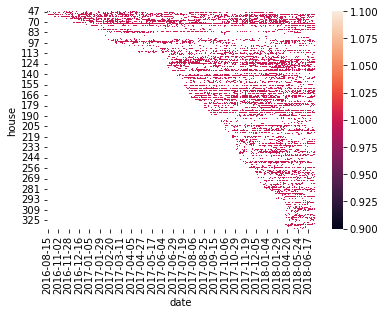

In [201]:
sns.heatmap(summary_file.sort_values('house').pivot(index='house', columns='date', values='point'))

In [203]:
summary_file.date.value_counts()

2018-04-23    84
2018-05-07    78
2018-04-25    75
2018-05-06    74
2018-05-27    74
              ..
2016-09-12     1
2016-09-02     1
2016-11-06     1
2017-01-15     1
2016-10-16     1
Name: date, Length: 411, dtype: int64

Let's use 23 April 2018 as we have most houses then. Let's get a list of houses that have data for that date:

In [230]:
date_required = summary_file.date.value_counts().index[0]

In [214]:
summary_file[summary_file.date == summary_file.date.value_counts().index[0]].house.values

array([229, 155, 209, 316, 250, 325, 186, 215, 177, 260,  67, 304, 323,
       284, 191,  74,  97, 168, 122, 188, 232, 158,  77, 292, 286, 153,
       139, 226, 305,  62, 290, 282, 231, 179, 120, 125, 238, 278, 237,
       263, 277, 123, 233, 242, 281, 208,  93, 330, 159, 128, 194, 321,
       166, 310, 203, 300,  98,  96, 241, 124, 146, 235,  72, 107,  70,
       261, 255, 298, 189,  64, 212, 156, 129, 135, 246, 144, 175,  79,
       178, 119, 162, 184, 240, 136])

In [222]:
houses_to_keep = summary_file[summary_file.date == summary_file.date.value_counts().index[0]].house.values
houses_to_keep = ['home' + str(num) + '.csv' for num in houses_to_keep]
houses_to_keep_files = [final_ideal_folder + x for x in houses_to_keep]

Okay, let's go and combine these files:

In [228]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
pd.read_csv(houses_to_keep_files[0], parse_dates = [0], date_parser = custom_date_parser)

,datetime,house,kilowatt
0,2017-11-10 00:00:00,229.0,0.497
1,2017-11-10 00:00:01,229.0,0.502
2,2017-11-10 00:00:02,229.0,0.505
3,2017-11-10 00:00:03,229.0,0.500
4,2017-11-10 00:00:04,229.0,0.512
...,...,...,...
5529595,2018-06-29 23:59:55,229.0,0.155
5529596,2018-06-29 23:59:56,229.0,0.153
5529597,2018-06-29 23:59:57,229.0,0.153
5529598,2018-06-29 23:59:58,229.0,0.153


In [234]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

solo_date = pd.DataFrame()

for fname in houses_to_keep_files:
    temp_ = pd.read_csv(houses_to_keep_files[0], parse_dates = [0], date_parser = custom_date_parser)
    temp_ = temp_[temp_.datetime.dt.date == date_required]
    solo_date = pd.concat([solo_date, temp_])

In [191]:
# custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

# summary_ = pd.DataFrame()

# for file in tqdm.tqdm([final_ideal_folder + i for i in os.listdir(final_ideal_folder)][10]):
    
#     temp_ = pd.read_csv(file, parse_dates = [0], date_parser = custom_date_parser)
#     temp_summary_ = pd.DataFrame([temp_.datetime.dt.date.unique()])
#     temp_summary_['house'] = temp_.loc[0, 'house']
#     summary_ = pd.concat([summary_, temp_summary_])
    